https://www.kaggle.com/code/meenaaa/cancer-death-rate-xgboost/notebook

https://www.researchgate.net/publication/341042405_On_linear_regression_models_with_hierarchical_categorical_variables

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# statistical analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scikit-learn
from sklearn.model_selection import train_test_split

import time

In [4]:
import numpy as np
import pandas as pd
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import *
# from tensorflow.keras import *
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from pickle import load

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
trainset = pd.read_csv("/content/drive/My Drive/DataMining/POC/LungCancer/Dataset/Transform/trainset.csv", index_col = 0)
trainset.head(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,City,State,Region,Division,TARGET_deathRate
Geography,,,,,,,,,,,,,,,,,,,,,
"Greene County, North Carolina",0.083439,0.122371,0.291870,0.133236,0.846543,0.0,0.5344,0,0.494915,0.592934,...,0.055978,1.000000,0.478172,0.891040,0.407456,603,33,2,6,0.648195
"McHenry County, Illinois",1.000000,1.000000,1.000000,1.000000,0.124789,0.0,0.5440,8,0.535593,0.549923,...,0.982636,0.522842,0.886624,0.457204,0.401518,948,13,0,0,0.739132
"Wichita County, Kansas",1.000000,0.009178,0.614898,0.008714,0.279933,0.0,0.4288,6,0.410169,0.559140,...,0.118496,0.574822,0.788191,0.753252,0.388981,1614,16,0,7,0.682701
"Mineral County, Montana",0.024442,0.027533,0.275623,0.022454,0.475548,0.0,1.0000,0,1.000000,0.872504,...,0.061625,0.028026,0.543234,0.355567,0.425932,984,26,3,3,0.913427
"Ohio County, West Virginia",0.254530,0.367113,0.350392,0.277148,0.512648,1.0,0.6720,1,0.640678,0.700461,...,0.317203,0.057158,0.455453,0.347449,0.411415,1085,48,2,6,0.810853


In [7]:
valset = pd.read_csv("/content/drive/My Drive/DataMining/POC/LungCancer/Dataset/Transform/valset.csv", index_col = 0)
valset.head(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,TARGET_deathRate,City,State,Region,Division
Geography,,,,,,,,,,,,,,,,,,,,,
"Linn County, Oregon",0.563843,0.826004,0.433484,0.785557,0.536256,0.039546,0.5504,3,0.555932,0.556068,...,0.456603,0.244924,0.658341,0.496995,0.418344,0.747251,139,32,3,5
"Champaign County, Illinois",0.653182,0.807648,0.505499,1.108948,0.654300,0.961857,0.2240,4,0.196610,0.258065,...,0.980500,0.193658,0.382380,0.369846,0.306170,0.673636,40,8,0,0
"Saratoga County, New York",0.933418,1.073805,0.982915,1.108948,0.134907,0.126423,0.6240,8,0.627119,0.632873,...,0.885327,0.077846,0.680359,0.482247,0.377763,0.831963,228,27,1,2
"Montmorency County, Michigan",0.069111,0.104015,0.305802,0.055315,0.421585,0.000000,0.9616,1,0.959322,0.987711,...,0.000000,0.067381,0.599090,0.348074,0.487958,0.766196,172,17,0,0
"Barrow County, Georgia",0.231774,0.339579,0.540069,0.489118,0.330523,0.000000,0.4000,5,0.355932,0.427035,...,0.980500,0.391169,0.735752,0.567292,0.436490,0.693934,8,6,2,6


In [8]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, Greene County, North Carolina to Van Wert County, Ohio
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              2467 non-null   float64
 1   avgDeathsPerYear         2467 non-null   float64
 2   incidenceRate            2467 non-null   float64
 3   medIncome                2467 non-null   float64
 4   popEst2015               2467 non-null   float64
 5   povertyPercent           2467 non-null   float64
 6   studyPerCap              2467 non-null   float64
 7   binnedInc                2467 non-null   int64  
 8   MedianAge                2467 non-null   float64
 9   MedianAgeMale            2467 non-null   float64
 10  MedianAgeFemale          2467 non-null   float64
 11  AvgHouseholdSize         2467 non-null   float64
 12  PercentMarried           2467 non-null   float64
 13  PctNoHS18_24             2467 non-null

In [9]:
valset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, Linn County, Oregon to Macon County, Missouri
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              305 non-null    float64
 1   avgDeathsPerYear         305 non-null    float64
 2   incidenceRate            305 non-null    float64
 3   medIncome                305 non-null    float64
 4   popEst2015               305 non-null    float64
 5   povertyPercent           305 non-null    float64
 6   studyPerCap              305 non-null    float64
 7   binnedInc                305 non-null    int64  
 8   MedianAge                305 non-null    float64
 9   MedianAgeMale            305 non-null    float64
 10  MedianAgeFemale          305 non-null    float64
 11  AvgHouseholdSize         305 non-null    float64
 12  PercentMarried           305 non-null    float64
 13  PctNoHS18_24             305 non-null    float64

In [10]:
X_train = trainset.drop(['TARGET_deathRate'], axis = 1)
y_train = trainset['TARGET_deathRate']

In [11]:
X_val = valset.drop(['TARGET_deathRate'], axis = 1)
y_val = valset['TARGET_deathRate']

In [12]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2467, 36) (2467,)
(305, 36) (305,)


In [13]:
import pickle
rfe_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Transform/minmax_rfe.h5'
rfe_fit = pickle.load(open(rfe_filename, 'rb'))

In [14]:
X_train_rfe = rfe_fit.transform(X_train)
X_val_rfe = rfe_fit.transform(X_val)
print(X_train_rfe.shape, y_train.shape)
print(X_val_rfe.shape, y_val.shape)

(2467, 18) (2467,)
(305, 18) (305,)


In [15]:
import joblib
scaler_single_filename = "/content/drive/My Drive/DataMining/POC/LungCancer/Model/Scaler/scaler_single.save"
scaler_single = joblib.load(scaler_single_filename) 

# Measure

In [16]:
#evaluation metrics for regression model
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error, r2_score

In [17]:
def deviation_function(y_val, pred):
  deviation = []
  for i in range(0, len(y_val)):
    deviation.append(abs(pred[i] - y_val[i]) / y_val[i])
  return np.array(deviation).mean()

# Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [18]:
#linear regression model
import optuna
from sklearn.linear_model import LinearRegression 
import sklearn.model_selection
#Grid search model
# from sklearn.model_selection import GridSearchCV         

In [19]:
def LR_Model(trial):
  fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
  copy_X = trial.suggest_categorical('copy_X', [True, False])
  lr = LinearRegression(copy_X = copy_X, fit_intercept = fit_intercept)
  score = sklearn.model_selection.cross_val_score(lr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [20]:
lr_study = optuna.create_study(direction="maximize")
lr_study.optimize(LR_Model, n_trials=4)
print(lr_study.best_trial)

[I 2023-05-10 01:50:13,040] A new study created in memory with name: no-name-e75b2073-afab-41a3-9764-8798f7642d4c
[I 2023-05-10 01:50:13,126] Trial 0 finished with value: 0.35788808824425694 and parameters: {'fit_intercept': True, 'copy_X': False}. Best is trial 0 with value: 0.35788808824425694.
[I 2023-05-10 01:50:13,199] Trial 1 finished with value: 0.3424130148982791 and parameters: {'fit_intercept': False, 'copy_X': False}. Best is trial 0 with value: 0.35788808824425694.
[I 2023-05-10 01:50:13,281] Trial 2 finished with value: 0.35788808824425694 and parameters: {'fit_intercept': True, 'copy_X': False}. Best is trial 0 with value: 0.35788808824425694.
[I 2023-05-10 01:50:13,356] Trial 3 finished with value: 0.3424130148982791 and parameters: {'fit_intercept': False, 'copy_X': True}. Best is trial 0 with value: 0.35788808824425694.


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.35788808824425694], datetime_start=datetime.datetime(2023, 5, 10, 1, 50, 13, 51596), datetime_complete=datetime.datetime(2023, 5, 10, 1, 50, 13, 125886), params={'fit_intercept': True, 'copy_X': False}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'fit_intercept': CategoricalDistribution(choices=(True, False)), 'copy_X': CategoricalDistribution(choices=(True, False))}, trial_id=0, value=None)


In [21]:
plot_optimization_history(lr_study)

In [22]:
lr_study.best_trial.params

{'fit_intercept': True, 'copy_X': False}

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [23]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/Parameter/Transform/lr_parameter.npy", lr_study.best_trial.params)

In [24]:
lr = LinearRegression(**lr_study.best_trial.params)


In [25]:
#training the model
lr_model = lr.fit(X_train_rfe,y_train) 
lr_pred = lr_model.predict(X_val_rfe)

## Evaluate

In [26]:
y_val_inv = scaler_single.inverse_transform(np.array(y_val).reshape(1, -1))
lr_pred_inv = scaler_single.inverse_transform(np.array(lr_pred).reshape(1, -1))

In [27]:
#evaluating the model with the following metrics
#mean squared error
lr_mse=mean_squared_error(lr_pred_inv[0], y_val_inv[0])     
#mean absolute error     
lr_mae=mean_absolute_error(lr_pred_inv[0], y_val_inv[0])  
#root mean squared error      
lr_rmse=np.sqrt(mean_squared_error(lr_pred_inv[0], y_val_inv[0]))
#r2 score
lr_r2 = r2_score(lr_pred_inv[0], y_val_inv[0])
print(f'mse: {lr_mse}')
print(f'mae: {lr_mae}')
print(f'rmse: {lr_rmse}')
print(f"R-Squared: {lr_r2}")

mse: 1218.1561819182766
mae: 26.72208589522402
rmse: 34.90209423398941
R-Squared: -0.97963576244229


In [28]:
lr_df =pd.DataFrame({"mse": lr_mse,"mae": lr_mae,"rmse": lr_rmse, "r2": lr_r2, "deviation": deviation_function(lr_pred_inv[0], y_val_inv[0])},index=['Linear Regression'])

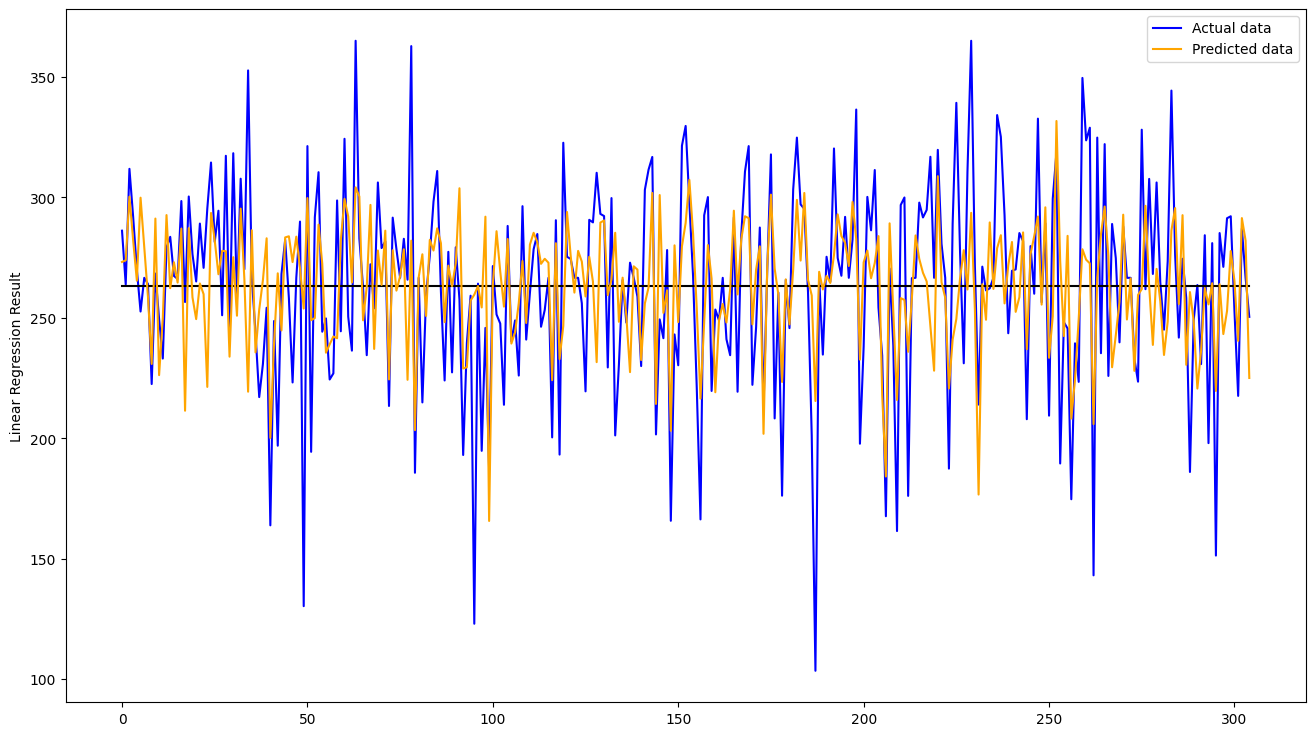

In [29]:
Axis = [y_val_inv[0].mean()] * len(y_val_inv[0])
plt.figure(figsize=(16, 9))
plt.ylabel('Linear Regression Result')
plt.plot(y_val_inv[0], 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(lr_pred_inv[0], 'orange', label='Predicted data')
plt.legend()

# Decision Tree Regression

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [30]:
# decision tree regression model
from sklearn.tree import DecisionTreeRegressor             

In [31]:
def DTR_Model(trial):
  criterion = trial.suggest_categorical('criterion', ["squared_error", "friedman_mse", "absolute_error", "poisson"])
  splitter = trial.suggest_categorical('splitter', ["best", "random"])
  max_features = trial.suggest_categorical('max_features', ["auto", "sqrt", "log2", None])
  dtr = DecisionTreeRegressor(criterion=criterion, max_features = max_features, splitter = splitter)
  
  score = sklearn.model_selection.cross_val_score(dtr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [32]:
dtr_study = optuna.create_study(direction="maximize")
dtr_study.optimize(DTR_Model, n_trials=32)
print(dtr_study.best_trial)

[I 2023-05-10 01:50:14,746] A new study created in memory with name: no-name-c02c424c-5ada-430b-95cc-09ad62804ad0
[I 2023-05-10 01:50:14,848] Trial 0 finished with value: -0.27434388307861696 and parameters: {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'sqrt'}. Best is trial 0 with value: -0.27434388307861696.
[I 2023-05-10 01:50:14,893] Trial 1 finished with value: -0.26769561152048355 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'max_features': 'sqrt'}. Best is trial 1 with value: -0.26769561152048355.
[I 2023-05-10 01:50:14,943] Trial 2 finished with value: -0.18720227476742438 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'max_features': None}. Best is trial 2 with value: -0.18720227476742438.
[I 2023-05-10 01:50:16,754] Trial 3 finished with value: -0.1334595763698926 and parameters: {'criterion': 'absolute_error', 'splitter': 'best', 'max_features': None}. Best is trial 3 with value: -0.1334595763698926.
[I 2023-05-

FrozenTrial(number=28, state=TrialState.COMPLETE, values=[-0.0645641101216315], datetime_start=datetime.datetime(2023, 5, 10, 1, 50, 49, 719550), datetime_complete=datetime.datetime(2023, 5, 10, 1, 50, 49, 811558), params={'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'auto'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'criterion': CategoricalDistribution(choices=('squared_error', 'friedman_mse', 'absolute_error', 'poisson')), 'splitter': CategoricalDistribution(choices=('best', 'random')), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2', None))}, trial_id=28, value=None)


In [33]:
plot_optimization_history(dtr_study)

In [34]:
dtr_study.best_trial.params

{'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'auto'}

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [35]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Transform/dtr_parameter.npy", dtr_study.best_trial.params)

In [36]:
dtr = DecisionTreeRegressor(**dtr_study.best_trial.params)

In [37]:
#training the model
dtr_model = dtr.fit(X_train_rfe,y_train) 
dtr_pred = dtr_model.predict(X_val_rfe)

## Evaluate

In [38]:
y_val_inv = scaler_single.inverse_transform(np.array(y_val).reshape(1, -1))
dtr_pred_inv = scaler_single.inverse_transform(np.array(dtr_pred).reshape(1, -1))

In [39]:
#evaluating the model with the following metrics
#mean squared error
dtr_mse=mean_squared_error(dtr_pred_inv[0], y_val_inv[0])     
#mean absolute error     
dtr_mae=mean_absolute_error(dtr_pred_inv[0], y_val_inv[0])  
#root mean squared error      
dtr_rmse=np.sqrt(mean_squared_error(dtr_pred_inv[0], y_val_inv[0]))
#r2 score
dtr_r2 = r2_score(dtr_pred_inv[0], y_val_inv[0])
print(f'mse: {dtr_mse}')
print(f'mae: {dtr_mae}')
print(f'rmse: {dtr_rmse}')
print(f"R-Squared: {dtr_r2}")


mse: 3279.798948797287
mae: 45.38581109884098
rmse: 57.269528973069846
R-Squared: -275.0744830072094


In [40]:
dtr_df =pd.DataFrame({"mse": dtr_mse,"mae": dtr_mae,"rmse": dtr_rmse, "r2": dtr_r2, "deviation": deviation_function(y_val_inv[0], dtr_pred_inv[0])},index=['Decision Tree Regression'])

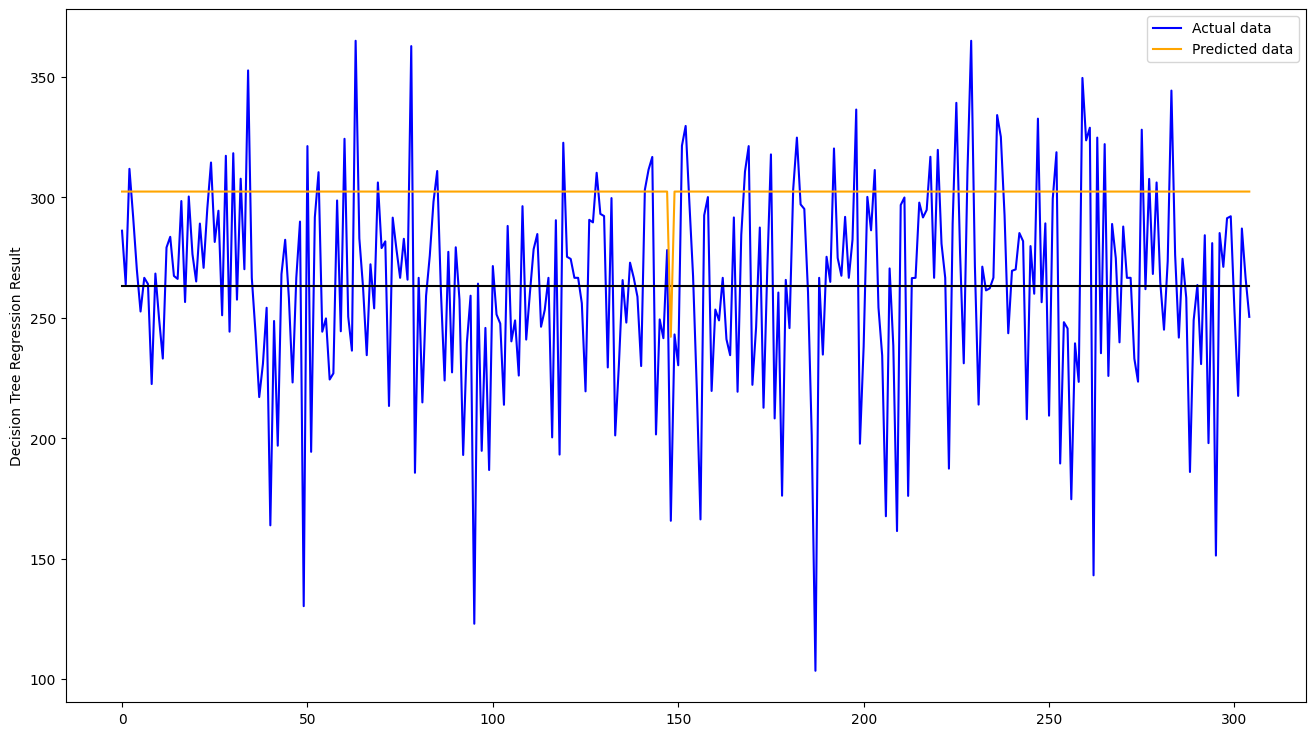

In [41]:
Axis = [y_val_inv[0].mean()] * len(y_val_inv[0])
plt.figure(figsize=(16, 9))
plt.ylabel('Decision Tree Regression Result')
plt.plot(y_val_inv[0], 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(dtr_pred_inv[0], 'orange', label='Predicted data')
plt.legend()

# Random Forest Regression

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [42]:
# random forest regression model
from sklearn.ensemble import RandomForestRegressor             

In [43]:
def RFR_Model(trial):
  criterion = trial.suggest_categorical('criterion', ["squared_error", "friedman_mse", "absolute_error", "poisson"])
  max_features = trial.suggest_categorical('max_features', [1, "sqrt", "log2", None])
  rfr = RandomForestRegressor(criterion=criterion, max_features = max_features)
  
  score = sklearn.model_selection.cross_val_score(rfr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [44]:
rfr_study = optuna.create_study(direction="maximize")
rfr_study.optimize(RFR_Model, n_trials=16)
print(rfr_study.best_trial)

[I 2023-05-10 01:50:50,598] A new study created in memory with name: no-name-b1318a2f-b510-43a0-8d7b-f8ee98b11007
[I 2023-05-10 01:50:58,032] Trial 0 finished with value: 0.44924099424554464 and parameters: {'criterion': 'friedman_mse', 'max_features': None}. Best is trial 0 with value: 0.44924099424554464.
[I 2023-05-10 01:51:04,704] Trial 1 finished with value: 0.4371456163976714 and parameters: {'criterion': 'poisson', 'max_features': None}. Best is trial 0 with value: 0.44924099424554464.
[I 2023-05-10 01:52:06,105] Trial 2 finished with value: 0.44749186664865204 and parameters: {'criterion': 'absolute_error', 'max_features': None}. Best is trial 0 with value: 0.44924099424554464.
[I 2023-05-10 01:52:22,933] Trial 3 finished with value: 0.4411800689748668 and parameters: {'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 0 with value: 0.44924099424554464.
[I 2023-05-10 01:52:39,845] Trial 4 finished with value: 0.43484926482063696 and parameters: {'criterion': 

FrozenTrial(number=12, state=TrialState.COMPLETE, values=[0.4561409370831439], datetime_start=datetime.datetime(2023, 5, 10, 1, 54, 0, 888853), datetime_complete=datetime.datetime(2023, 5, 10, 1, 54, 8, 213957), params={'criterion': 'squared_error', 'max_features': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'criterion': CategoricalDistribution(choices=('squared_error', 'friedman_mse', 'absolute_error', 'poisson')), 'max_features': CategoricalDistribution(choices=(1, 'sqrt', 'log2', None))}, trial_id=12, value=None)


In [45]:
plot_optimization_history(rfr_study)

In [46]:
rfr_study.best_trial.params

{'criterion': 'squared_error', 'max_features': None}

In [47]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Transform/rfr_parameter.npy", rfr_study.best_trial.params)

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [48]:
rfr = RandomForestRegressor(**rfr_study.best_trial.params)

In [49]:
#training the model
rfr_model = rfr.fit(X_train_rfe,y_train) 
rfr_pred = rfr_model.predict(X_val_rfe)

## Evaluate

In [50]:
y_val_inv = scaler_single.inverse_transform(np.array(y_val).reshape(1, -1))
rfr_pred_inv = scaler_single.inverse_transform(np.array(rfr_pred).reshape(1, -1))

In [51]:
#evaluating the model with the following metrics
#mean squared error
rfr_mse=mean_squared_error(rfr_pred_inv[0], y_val_inv[0])     
#mean absolute error     
rfr_mae=mean_absolute_error(rfr_pred_inv[0], y_val_inv[0])  
#root mean squared error      
rfr_rmse=np.sqrt(mean_squared_error(rfr_pred_inv[0], y_val_inv[0]))
#r2 score
rfr_r2 = r2_score(rfr_pred_inv[0], y_val_inv[0])
print(f'mse: {rfr_mse}')
print(f'mae: {rfr_mae}')
print(f'rmse: {rfr_rmse}')
print(f"R-Squared: {rfr_r2}")


mse: 2073.4110225015907
mae: 33.9356017125043
rmse: 45.534723261502215
R-Squared: -303.54052398940183


In [52]:
rfr_df =pd.DataFrame({"mse": rfr_mse,"mae": rfr_mae,"rmse": rfr_rmse, "r2": rfr_r2, "deviation": deviation_function(rfr_pred_inv[0], y_val_inv[0])},index=['Random Forest Regression'])

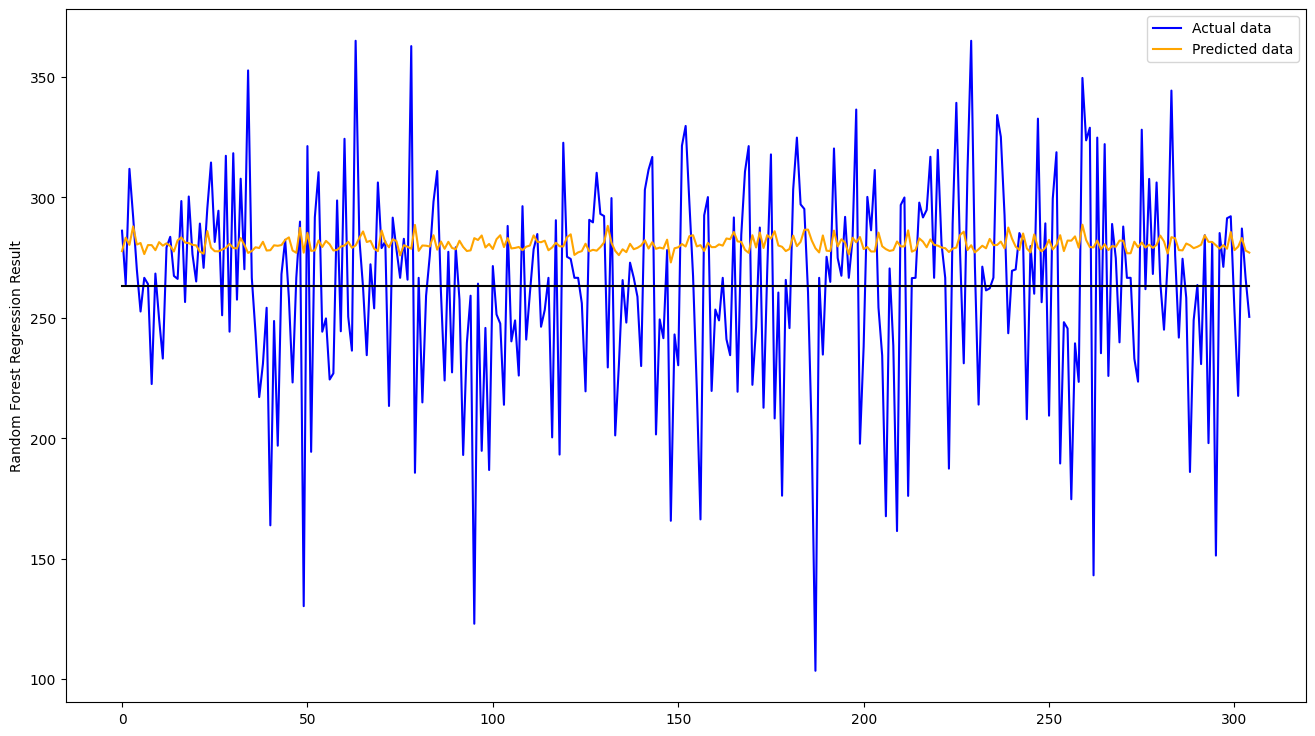

In [53]:
Axis = [y_val_inv[0].mean()] * len(y_val_inv[0])
plt.figure(figsize=(16, 9))
plt.ylabel('Random Forest Regression Result')
plt.plot(y_val_inv[0], 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(rfr_pred_inv[0], 'orange', label='Predicted data')
plt.legend()


# XGBoost Regression

https://stackabuse.com/bytes/end-to-end-xgboost-regression-pipeline-with-scikit-learn/

https://xgboost.readthedocs.io/

In [54]:
# pip install xgboost

In [55]:
# xgboost model
from xgboost import XGBRegressor            

In [56]:
def XGBR_Model(trial):
  booster = trial.suggest_categorical('booster', ["gbtree", "gblinear", "dart"])
  grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
  gamma = trial.suggest_float("gamma", 0.1, 1.0, step=0.1)
  max_depth = trial.suggest_int("max_depth", 1, 20, step=1)
  n_estimators = trial.suggest_int("max_depth", 500, 3000, step=500)
  learning_rate = trial.suggest_float("learning_rate", 0.1, 1, step=0.1)
  xgbr = XGBRegressor(booster = booster, grow_policy = grow_policy, gamma = gamma, max_depth = max_depth, n_estimators = n_estimators, learning_rate = learning_rate)
  score = sklearn.model_selection.cross_val_score(xgbr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [57]:
xgbr_study = optuna.create_study(direction="maximize")
xgbr_study.optimize(XGBR_Model, n_trials=1000)
print(xgbr_study.best_trial)

[I 2023-05-10 01:55:28,743] A new study created in memory with name: no-name-70ca38e1-9780-4d32-a710-59f6fd53e298
[I 2023-05-10 01:55:28,932] Trial 0 finished with value: -0.2175081608252687 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.5, 'max_depth': 6, 'learning_rate': 0.1}. Best is trial 0 with value: -0.2175081608252687.
[I 2023-05-10 01:55:29,096] Trial 1 finished with value: 0.33694359744063257 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 7, 'learning_rate': 0.7000000000000001}. Best is trial 1 with value: 0.33694359744063257.
[I 2023-05-10 01:55:29,881] Trial 2 finished with value: 0.3419279570456139 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 16, 'learning_rate': 0.5}. Best is trial 2 with value: 0.3419279570456139.
[I 2023-05-10 01:55:29,977] Trial 3 finished with value: 0.013682912878137166 and parameters: {'booster': 'dart', 'grow_pol

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:30,531] Trial 7 finished with value: 0.2870638525976101 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.8, 'max_depth': 10, 'learning_rate': 0.7000000000000001}. Best is trial 5 with value: 0.35796619942701025.
[I 2023-05-10 01:55:30,577] Trial 8 finished with value: 0.3570756386187351 and parameters: {'booster': 'gblinear', 'grow_policy': 'depthwise', 'gamma': 0.6, 'max_depth': 13, 'learning_rate': 0.4}. Best is trial 5 with value: 0.35796619942701025.


[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:30,909] Trial 9 finished with value: 0.36871419871405414 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.30000000000000004, 'max_depth': 10, 'learning_rate': 0.4}. Best is trial 9 with value: 0.36871419871405414.
[I 2023-05-10 01:55:34,510] Trial 10 finished with value: 0.21513871864790032 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 1.0}. Best is trial 9 with value: 0.36871419871405414.


[01:55:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:35,074] Trial 11 finished with value: -0.5116446574302405 and parameters: {'booster': 'gblinear', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 1, 'learning_rate': 0.30000000000000004}. Best is trial 9 with value: 0.36871419871405414.


[01:55:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:35,242] Trial 12 finished with value: 0.3577199957677834 and parameters: {'booster': 'gblinear', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 10, 'learning_rate': 1.0}. Best is trial 9 with value: 0.36871419871405414.


[01:55:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:36,090] Trial 13 finished with value: 0.35480439137724834 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.2, 'max_depth': 16, 'learning_rate': 0.8}. Best is trial 9 with value: 0.36871419871405414.
[I 2023-05-10 01:55:36,157] Trial 14 finished with value: 0.35717618257196554 and parameters: {'booster': 'gblinear', 'grow_policy': 'depthwise', 'gamma': 0.30000000000000004, 'max_depth': 13, 'learning_rate': 0.4}. Best is trial 9 with value: 0.36871419871405414.


[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:36,429] Trial 15 finished with value: 0.32278903715040236 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 8, 'learning_rate': 0.9}. Best is trial 9 with value: 0.36871419871405414.
[I 2023-05-10 01:55:36,498] Trial 16 finished with value: 0.35770940999310463 and parameters: {'booster': 'gblinear', 'grow_policy': 'depthwise', 'gamma': 0.2, 'max_depth': 16, 'learning_rate': 0.5}. Best is trial 9 with value: 0.36871419871405414.
[I 2023-05-10 01:55:36,571] Trial 17 finished with value: 0.3579195553620518 and parameters: {'booster': 'gblinear', 'grow_policy': 'depthwise', 'gamma': 0.5, 'max_depth': 20, 'learning_rate': 0.6}. Best is trial 9 with value: 0.36871419871405414.


[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:36,971] Trial 18 finished with value: 0.40372091450909453 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 11, 'learning_rate': 0.4}. Best is trial 18 with value: 0.40372091450909453.
[I 2023-05-10 01:55:37,269] Trial 19 finished with value: 0.3374117044358755 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.4, 'max_depth': 9, 'learning_rate': 0.30000000000000004}. Best is trial 18 with value: 0.40372091450909453.
[I 2023-05-10 01:55:37,348] Trial 20 finished with value: -0.6500923745602168 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 3, 'learning_rate': 0.1}. Best is trial 18 with value: 0.40372091450909453.
[I 2023-05-10 01:55:37,831] Trial 21 finished with value: 0.4037396633270429 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 12, 'learning_rate': 0.4}. Best is trial 21 with value: 0.403739663327042

[01:56:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:30] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:56:31,883] Trial 69 finished with value: 0.342739513305468 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 17, 'learning_rate': 0.9}. Best is trial 45 with value: 0.44200181591455306.
[I 2023-05-10 01:56:32,704] Trial 70 finished with value: 0.3878123786586543 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.2, 'max_depth': 16, 'learning_rate': 0.5}. Best is trial 45 with value: 0.44200181591455306.
[I 2023-05-10 01:56:33,674] Trial 71 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:56:34,630] Trial 72 finished with value: 0.42942089364999986 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334

[01:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:56:40,628] Trial 78 finished with value: 0.4294206513638306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:56:40,872] Trial 79 finished with value: 0.2087418088418168 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.4, 'max_depth': 4, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:56:44,111] Trial 80 finished with value: 0.44200119247240716 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:56:45,258] Trial 81 finished with value: 0.44200119247240716 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial

[01:56:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:56:51,837] Trial 89 finished with value: 0.415555874492828 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 11, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:56:52,631] Trial 90 finished with value: 0.407992970586396 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 16, 'learning_rate': 0.2}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:56:56,626] Trial 91 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:56:57,583] Trial 92 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0

[01:57:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:57:14,287] Trial 109 finished with value: 0.4087509195642329 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 15, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:57:15,186] Trial 110 finished with value: 0.4397052517819698 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.2}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:57:16,139] Trial 111 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:57:17,099] Trial 112 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is 

[01:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:57:38,443] Trial 130 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:57:39,433] Trial 131 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:57:40,412] Trial 132 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:57:41,497] Trial 133 finished with value: 0.40208644098483387 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.6}. Best i

[01:58:09] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:09] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:09] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:58:10,238] Trial 157 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:58:11,212] Trial 158 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:58:12,111] Trial 159 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:58:13,116] Trial 160 finished with value: 0.42942089364999986 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.4}. Best is

[01:58:46] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:46] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:46] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:58:47,856] Trial 187 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:58:48,919] Trial 188 finished with value: 0.4037558341796845 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 19, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:58:49,887] Trial 189 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:58:50,778] Trial 190 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is 

[01:59:22] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:59:23] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:59:24] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:59:25,272] Trial 219 finished with value: 0.35436467700584906 and parameters: {'booster': 'gblinear', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 12, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:59:26,669] Trial 220 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:59:27,647] Trial 221 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 01:59:28,618] Trial 222 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000

[02:00:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:00:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:00:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:00:14,112] Trial 255 finished with value: 0.4294206513638306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:00:15,104] Trial 256 finished with value: 0.4414401843733022 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.2}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:00:16,101] Trial 257 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:00:17,166] Trial 258 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with va

[02:00:40] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:00:40] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:00:40] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:00:41,207] Trial 277 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:00:42,183] Trial 278 finished with value: 0.40872984695731446 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.2}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:00:42,424] Trial 279 finished with value: 0.23989482213501645 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 1.0, 'max_depth': 8, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:00:42,811] Trial 280 finished with value: 0.4326996823515803 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 10, 'learning_rate': 0.30000000000000004}. Best is 

[02:01:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:01:08,575] Trial 301 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:01:09,573] Trial 302 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:01:10,535] Trial 303 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:01:11,654] Trial 304 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000

[02:01:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:01:35,053] Trial 323 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:01:36,132] Trial 324 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:01:37,052] Trial 325 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:01:38,067] Trial 326 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000

[02:01:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:02:00,091] Trial 344 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:01,056] Trial 345 finished with value: 0.2615477997268641 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.8, 'max_depth': 18, 'learning_rate': 0.2}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:01,954] Trial 346 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:03,024] Trial 347 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is 

[02:02:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:02:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:02:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:02:27,608] Trial 368 finished with value: 0.42942089364999986 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:28,510] Trial 369 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:29,267] Trial 370 finished with value: 0.43289880537947734 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 15, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:30,442] Trial 371 finished with value: 0.44200119247240716 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is

[02:02:50] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:02:50,741] Trial 388 finished with value: 0.35677122451933085 and parameters: {'booster': 'gblinear', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.


[02:02:50] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:02:50] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:02:51,472] Trial 389 finished with value: 0.33950202364820753 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 4, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:53,584] Trial 390 finished with value: 0.3223700023468254 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.5, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:54,571] Trial 391 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:02:55,661] Trial 392 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is 

[02:03:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:03:17,454] Trial 412 finished with value: 0.42942089364999986 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:03:20,773] Trial 413 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:03:21,830] Trial 414 finished with value: 0.25831563892453235 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.9, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:03:22,727] Trial 415 finished with value: 0.4397052517819698 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.2}. Best is trial 71 with va

[02:03:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:03:42,134] Trial 433 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:03:43,135] Trial 434 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:03:47,315] Trial 435 finished with value: 0.4294210342977216 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:03:48,275] Trial 436 finished with value: 0.4104285018202865 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.5}. Best is trial 71 with va

[02:04:08] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:08] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:08] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:04:09,345] Trial 455 finished with value: 0.4417141329430511 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:04:10,386] Trial 456 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:04:12,513] Trial 457 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:04:15,522] Trial 458 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is

[02:04:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:04:36,171] Trial 478 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:04:37,157] Trial 479 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:04:38,386] Trial 480 finished with value: 0.40877828517932047 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:04:42,192] Trial 481 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.300000000000

[02:05:00] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:00] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:00] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:05:01,905] Trial 499 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:03,032] Trial 500 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:04,026] Trial 501 finished with value: 0.36881984205835666 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:04,899] Trial 502 finished with value: 0.4407275951757983 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 16, 'learning_rate': 0.30000000000

[02:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:05:26,366] Trial 521 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:27,434] Trial 522 finished with value: 0.44160816072046566 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:28,375] Trial 523 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:29,374] Trial 524 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is

[02:05:52] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:52] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:52] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:05:53,074] Trial 543 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:54,170] Trial 544 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:55,192] Trial 545 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:05:56,198] Trial 546 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000

[02:06:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:06:21,516] Trial 566 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:06:22,473] Trial 567 finished with value: 0.38385112670366034 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.7000000000000001}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:06:23,555] Trial 568 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:06:24,489] Trial 569 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.300000000000

[02:06:46] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:46] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:46] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:06:47,976] Trial 587 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:06:48,647] Trial 588 finished with value: 0.43286638951058487 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 14, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:06:49,563] Trial 589 finished with value: 0.3091945643612323 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.6, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:06:50,639] Trial 590 finished with value: 0.44160816072046566 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.2}. Best is

[02:07:14] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:14] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:14] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:07:15,787] Trial 610 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:07:16,712] Trial 611 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:07:17,253] Trial 612 finished with value: 0.2579350535015286 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 1.0, 'max_depth': 12, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:07:18,355] Trial 613 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is 

[02:07:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:07:42,128] Trial 632 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:07:43,042] Trial 633 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:07:44,036] Trial 634 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:07:45,050] Trial 635 finished with value: 0.37644564182986134 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 18, 'learning_rate

[02:08:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:08:08,912] Trial 654 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:08:09,254] Trial 655 finished with value: 0.4176065261635036 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 9, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:08:10,263] Trial 656 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:08:11,276] Trial 657 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.3000000000000

[02:08:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:08:34,063] Trial 675 finished with value: 0.3091945643612323 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.6, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:08:34,259] Trial 676 finished with value: 0.3781293215304918 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 6, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:08:34,368] Trial 677 finished with value: -0.1944592666485204 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 2, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:08:35,570] Trial 678 finished with value: 0.44200119247240716 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is tr

[02:08:55] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:55] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:55] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:09:00,000] Trial 698 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:01,012] Trial 699 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:02,022] Trial 700 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:03,105] Trial 701 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.3000000000

[02:09:22] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:22] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:22] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:09:23,263] Trial 719 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:27,272] Trial 720 finished with value: 0.3769074628774785 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.1}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:28,385] Trial 721 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:29,325] Trial 722 finished with value: 0.2583044056607234 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.9, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is 

[02:09:49] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:49] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:49] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:09:50,867] Trial 741 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:54,779] Trial 742 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:55,797] Trial 743 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:09:56,918] Trial 744 finished with value: 0.40877828517932047 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 19, 'learning_rate': 0.30000000000

[02:10:16] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:16] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:16] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:10:17,126] Trial 763 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:10:21,253] Trial 764 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:10:22,265] Trial 765 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:10:23,265] Trial 766 finished with value: 0.4414401843733022 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.2}. Best is 

[02:10:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:43] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:43] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:10:43,967] Trial 785 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:10:48,036] Trial 786 finished with value: 0.42942089364999986 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:10:49,147] Trial 787 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:10:50,165] Trial 788 finished with value: 0.4414401843733022 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.2}. Best is trial 71 with va

[02:11:10] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:11:10] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:11:10] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:11:14,581] Trial 808 finished with value: 0.2854801724560789 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.7000000000000001, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:11:15,956] Trial 809 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:11:16,971] Trial 810 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:11:18,077] Trial 811 finished with value: 0.4294210342977216 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate':

[02:11:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:11:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:11:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:11:38,148] Trial 829 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:11:42,252] Trial 830 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:11:43,268] Trial 831 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:11:44,260] Trial 832 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.3000000000

[02:12:05] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:12:05] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:12:05] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:12:09,607] Trial 852 finished with value: 0.42942089364999986 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:12:10,519] Trial 853 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:12:11,526] Trial 854 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:12:12,523] Trial 855 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is

[02:12:31] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:12:31] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:12:31] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:12:32,838] Trial 873 finished with value: 0.4294206513638306 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:12:36,854] Trial 874 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:12:37,876] Trial 875 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:12:38,955] Trial 876 finished with value: 0.24512808728185478 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is

[02:12:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:12:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:12:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:13:02,118] Trial 895 finished with value: 0.3300296710120368 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.5, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:13:04,722] Trial 896 finished with value: 0.4407275951757983 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 16, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:13:05,725] Trial 897 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:13:06,667] Trial 898 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is t

[02:13:28] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:13:28] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:13:28] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:13:32,162] Trial 918 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:13:33,173] Trial 919 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:13:34,124] Trial 920 finished with value: 0.2693287029714942 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.8, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:13:35,257] Trial 921 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000

[02:13:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:13:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:13:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:14:00,199] Trial 941 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:01,293] Trial 942 finished with value: 0.4294210342977216 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.4}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:02,340] Trial 943 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:03,311] Trial 944 finished with value: 0.4420012171397481 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is 

[02:14:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:14:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:14:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:14:27,186] Trial 963 finished with value: 0.44200181591455306 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:28,223] Trial 964 finished with value: 0.40877684930522457 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:29,145] Trial 965 finished with value: 0.3574171910095099 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.8}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:30,167] Trial 966 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is

[02:14:48] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:14:48] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:14:48] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:14:52,527] Trial 983 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:53,644] Trial 984 finished with value: 0.40877828517932047 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:54,637] Trial 985 finished with value: 0.44200208308334465 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}. Best is trial 71 with value: 0.44200208308334465.
[I 2023-05-10 02:14:55,586] Trial 986 finished with value: 0.4294206513638306 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.1, 'max_depth': 17, 'learning_rate': 0.4}. Best is

FrozenTrial(number=71, state=TrialState.COMPLETE, values=[0.44200208308334465], datetime_start=datetime.datetime(2023, 5, 10, 1, 56, 32, 706306), datetime_complete=datetime.datetime(2023, 5, 10, 1, 56, 33, 673927), params={'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 18, 'learning_rate': 0.30000000000000004}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide')), 'gamma': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'max_depth': IntDistribution(high=20, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1)}, trial_id=71, value=None)


In [58]:
plot_optimization_history(xgbr_study)

In [59]:
xgbr_study.best_trial.params

{'booster': 'gbtree',
 'grow_policy': 'lossguide',
 'gamma': 0.1,
 'max_depth': 18,
 'learning_rate': 0.30000000000000004}

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [60]:
xgbr = XGBRegressor(**xgbr_study.best_trial.params)

In [61]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Transform/xgbr_parameter.npy", xgbr_study.best_trial.params)

In [62]:
#training the model
xgbr_model = xgbr.fit(X_train_rfe,y_train) 
xgbr_pred = xgbr_model.predict(X_val_rfe)

## Evaluate

In [63]:
y_val_inv = scaler_single.inverse_transform(np.array(y_val).reshape(1, -1))
xgbr_pred_inv = scaler_single.inverse_transform(np.array(xgbr_pred).reshape(1, -1))

In [64]:
#evaluating the model with the following metrics
#mean squared error
xgbr_mse=mean_squared_error(xgbr_pred_inv[0], y_val_inv[0])     
#mean absolute error     
xgbr_mae=mean_absolute_error(xgbr_pred_inv[0], y_val_inv[0])  
#root mean squared error      
xgbr_rmse=np.sqrt(mean_squared_error(xgbr_pred_inv[0], y_val_inv[0]))
#r2 score
xgbr_r2 = r2_score(xgbr_pred_inv[0], y_val_inv[0])
print(f'mse: {xgbr_mse}')
print(f'mae: {xgbr_mae}')
print(f'rmse: {xgbr_rmse}')
print(f"R-Squared: {xgbr_r2}")

mse: 2359.0288175484256
mae: 37.07564306409703
rmse: 48.56983444019987
R-Squared: -49.442872323726455


In [65]:
xgbr_df =pd.DataFrame({"mse": xgbr_mse,"mae": xgbr_mae,"rmse": xgbr_rmse,  "r2": xgbr_r2, "deviation": deviation_function(xgbr_pred_inv[0], y_val_inv[0])},index=['XGBoost Regression'])

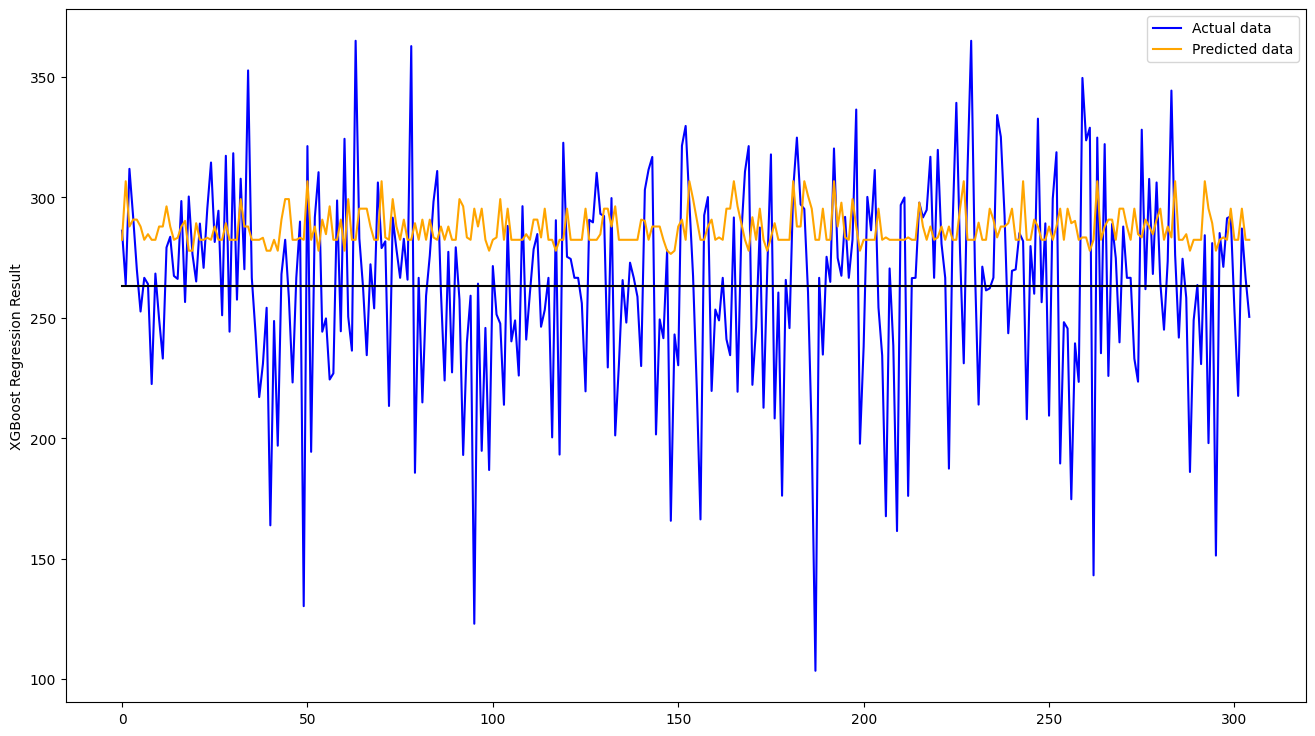

In [66]:
Axis = [y_val_inv[0].mean()] * len(y_val_inv[0])
plt.figure(figsize=(16, 9))
plt.ylabel('XGBoost Regression Result')
plt.plot(y_val_inv[0], 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(xgbr_pred_inv[0], 'orange', label='Predicted data')
plt.legend()


# Neural Network

https://stackabuse.com/bytes/end-to-end-xgboost-regression-pipeline-with-scikit-learn/

https://xgboost.readthedocs.io/

In [67]:
# pip install xgboost

In [68]:
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import RobustScaler, normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
def NN_Model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 6, step = 1)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model = Sequential()
    model.add(Flatten())
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 4096, log=True)
        dropout = trial.suggest_uniform("Dropout_rate", 0.01, 0.80)
        activation = trial.suggest_categorical('activation', ["relu", "tanh", "linear"])
        model.add(
            Dense(
                num_hidden,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
        model.add(Dropout(dropout))
    model.add(
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    model.compile(
      loss='mse',
      optimizer=Adam(learning_rate = learning_rate)
    )
    return model

In [70]:
EPOCHS = 30 # number of epocs per trial

def objective(trial):
    keras.backend.clear_session()
    # Generate our trial model.
    model = NN_Model(trial)

    # learning rate scheduler
    scheduler = ExponentialDecay(1e-3, 400*((len(X_train_rfe)*0.8)/16), 1e-5)
    lr = LearningRateScheduler(scheduler, verbose=0)

    # Fit the model on the training data.
    # The TFKerasPruningCallback checks for pruning condition every epoch.
    model.fit(
        X_train_rfe, y_train,
        batch_size=16,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")],
        epochs=EPOCHS,
        validation_data=(X_val_rfe, y_val),
        verbose=1,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_val_rfe, y_val, verbose=0)
    return score

In [71]:
nn_study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
nn_study.optimize(objective, n_trials=10)
pruned_trials = nn_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = nn_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2023-05-10 02:15:12,877] A new study created in memory with name: no-name-0aa96e08-b86c-4638-8bc1-67414deddacb


Epoch 1/30
155/155 [==============================] - 5s 21ms/step - loss: 0.2424 - val_loss: 0.0976
Epoch 2/30
155/155 [==============================] - 3s 23ms/step - loss: 0.1045 - val_loss: 0.1049
Epoch 3/30
155/155 [==============================] - 2s 15ms/step - loss: 0.0977 - val_loss: 0.0900
Epoch 4/30
155/155 [==============================] - 2s 15ms/step - loss: 0.0969 - val_loss: 0.0934
Epoch 5/30
155/155 [==============================] - 2s 15ms/step - loss: 0.0949 - val_loss: 0.0885
Epoch 6/30
155/155 [==============================] - 2s 15ms/step - loss: 0.0921 - val_loss: 0.0878
Epoch 7/30
155/155 [==============================] - 3s 19ms/step - loss: 0.0923 - val_loss: 0.0887
Epoch 8/30
155/155 [==============================] - 3s 22ms/step - loss: 0.0909 - val_loss: 0.0860
Epoch 9/30
155/155 [==============================] - 2s 15ms/step - loss: 0.0901 - val_loss: 0.0843
Epoch 10/30
155/155 [==============================] - 2s 15ms/step - loss: 0.0885 - val_lo

[I 2023-05-10 02:16:34,993] Trial 0 finished with value: 0.05992596596479416 and parameters: {'n_layers': 5, 'weight_decay': 0.00010924015768199327, 'learning_rate': 0.00011633243184232154, 'n_units_l0': 1183, 'Dropout_rate': 0.31579275510590754, 'activation': 'linear', 'n_units_l1': 145, 'n_units_l2': 3048, 'n_units_l3': 21, 'n_units_l4': 1146}. Best is trial 0 with value: 0.05992596596479416.


Epoch 1/30
155/155 [==============================] - 3s 4ms/step - loss: 148.1025 - val_loss: 0.3979
Epoch 2/30
155/155 [==============================] - 0s 3ms/step - loss: 110.1170 - val_loss: 0.4288
Epoch 3/30
155/155 [==============================] - 0s 3ms/step - loss: 62.2058 - val_loss: 0.4326
Epoch 4/30
155/155 [==============================] - 0s 3ms/step - loss: 82.8525 - val_loss: 0.4146
Epoch 5/30
155/155 [==============================] - 0s 3ms/step - loss: 89.6639 - val_loss: 0.4037
Epoch 6/30
155/155 [==============================] - 0s 3ms/step - loss: 43.3753 - val_loss: 0.3925
Epoch 7/30
155/155 [==============================] - 0s 3ms/step - loss: 29.8152 - val_loss: 0.3726
Epoch 8/30
155/155 [==============================] - 0s 3ms/step - loss: 37.3873 - val_loss: 0.3564
Epoch 9/30
155/155 [==============================] - 0s 3ms/step - loss: 19.9707 - val_loss: 0.3401
Epoch 10/30
155/155 [==============================] - 0s 3ms/step - loss: 21.4271 - val_

[I 2023-05-10 02:16:51,711] Trial 1 finished with value: 0.05285415053367615 and parameters: {'n_layers': 5, 'weight_decay': 5.5484361346074595e-09, 'learning_rate': 0.00048304945624482446, 'n_units_l0': 53, 'Dropout_rate': 0.7791152356640827, 'activation': 'relu', 'n_units_l1': 39, 'n_units_l2': 6, 'n_units_l3': 7, 'n_units_l4': 5}. Best is trial 1 with value: 0.05285415053367615.


Epoch 1/30
155/155 [==============================] - 2s 4ms/step - loss: 0.2797 - val_loss: 0.0655
Epoch 2/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0253
Epoch 3/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0210
Epoch 4/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0209
Epoch 5/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0377 - val_loss: 0.0212
Epoch 6/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0212
Epoch 7/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0208
Epoch 8/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0298 - val_loss: 0.0215
Epoch 9/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0276 - val_loss: 0.0211
Epoch 10/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0208

[I 2023-05-10 02:17:09,664] Trial 2 finished with value: 0.020691778510808945 and parameters: {'n_layers': 6, 'weight_decay': 8.1169828734133e-06, 'learning_rate': 0.00011188857399073458, 'n_units_l0': 4, 'Dropout_rate': 0.15025092220402592, 'activation': 'tanh', 'n_units_l1': 92, 'n_units_l2': 91, 'n_units_l3': 11, 'n_units_l4': 16, 'n_units_l5': 135}. Best is trial 2 with value: 0.020691778510808945.


Epoch 1/30
155/155 [==============================] - 1s 3ms/step - loss: 36.5407 - val_loss: 1.2264
Epoch 2/30
155/155 [==============================] - 0s 2ms/step - loss: 8.9750 - val_loss: 0.6894
Epoch 3/30
155/155 [==============================] - 0s 2ms/step - loss: 3.3434 - val_loss: 0.4205
Epoch 4/30
155/155 [==============================] - 0s 2ms/step - loss: 1.2070 - val_loss: 0.3047
Epoch 5/30
155/155 [==============================] - 0s 2ms/step - loss: 0.6544 - val_loss: 0.1139
Epoch 6/30
155/155 [==============================] - 0s 2ms/step - loss: 0.3881 - val_loss: 0.0678
Epoch 7/30
155/155 [==============================] - 0s 2ms/step - loss: 0.2547 - val_loss: 0.0363
Epoch 8/30
155/155 [==============================] - 0s 2ms/step - loss: 0.1707 - val_loss: 0.0297
Epoch 9/30
155/155 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0255
Epoch 10/30
155/155 [==============================] - 0s 2ms/step - loss: 0.0969 - val_loss: 0.021

[I 2023-05-10 02:17:30,943] Trial 3 finished with value: 0.05576125532388687 and parameters: {'n_layers': 1, 'weight_decay': 1.0477252217218847e-09, 'learning_rate': 0.001347685620764075, 'n_units_l0': 11, 'Dropout_rate': 0.7145626345053422, 'activation': 'linear'}. Best is trial 2 with value: 0.020691778510808945.


Epoch 1/30
155/155 [==============================] - 3s 14ms/step - loss: 0.5695 - val_loss: 0.0839
Epoch 2/30
155/155 [==============================] - 2s 13ms/step - loss: 0.3573 - val_loss: 0.3280
Epoch 3/30
155/155 [==============================] - 2s 11ms/step - loss: 0.3200 - val_loss: 0.1614
Epoch 4/30
155/155 [==============================] - 1s 8ms/step - loss: 0.2710 - val_loss: 0.0604
Epoch 5/30
155/155 [==============================] - 1s 8ms/step - loss: 0.2545 - val_loss: 0.0382
Epoch 6/30
155/155 [==============================] - 1s 8ms/step - loss: 0.2375 - val_loss: 0.1670
Epoch 7/30
155/155 [==============================] - 1s 8ms/step - loss: 0.2015 - val_loss: 0.0384
Epoch 8/30
155/155 [==============================] - 1s 8ms/step - loss: 0.1921 - val_loss: 0.0949
Epoch 9/30
155/155 [==============================] - 1s 9ms/step - loss: 0.1651 - val_loss: 0.1535
Epoch 10/30
151/155 [============================>.] - ETA: 0s - loss: 0.1463

[I 2023-05-10 02:17:47,013] Trial 4 pruned. Trial was pruned at epoch 9.


Epoch 1/30
155/155 [==============================] - 3s 5ms/step - loss: 2.2492 - val_loss: 2.2648
Epoch 2/30
140/155 [==========================>...] - ETA: 0s - loss: 2.0253

[I 2023-05-10 02:17:50,519] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/30
155/155 [==============================] - 2s 5ms/step - loss: 0.6134 - val_loss: 0.3885
Epoch 2/30
155/155 [==============================] - 1s 3ms/step - loss: 0.4966 - val_loss: 0.2460
Epoch 3/30
155/155 [==============================] - 1s 4ms/step - loss: 0.4121 - val_loss: 0.2218
Epoch 4/30
145/155 [===========================>..] - ETA: 0s - loss: 0.3440

[I 2023-05-10 02:17:55,031] Trial 6 pruned. Trial was pruned at epoch 3.


Epoch 1/30
155/155 [==============================] - 2s 7ms/step - loss: 1.3770 - val_loss: 0.0789
Epoch 2/30
155/155 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0250
Epoch 3/30
155/155 [==============================] - 1s 6ms/step - loss: 0.0216 - val_loss: 0.0201
Epoch 4/30
155/155 [==============================] - 1s 7ms/step - loss: 0.0195 - val_loss: 0.0199
Epoch 5/30
155/155 [==============================] - 1s 8ms/step - loss: 0.0198 - val_loss: 0.0198
Epoch 6/30
155/155 [==============================] - 2s 11ms/step - loss: 0.0198 - val_loss: 0.0200
Epoch 7/30
155/155 [==============================] - 2s 11ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 8/30
155/155 [==============================] - 1s 9ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 9/30
155/155 [==============================] - 1s 7ms/step - loss: 0.0199 - val_loss: 0.0195
Epoch 10/30
155/155 [==============================] - 1s 7ms/step - loss: 0.0200 - val_loss: 0.02

[I 2023-05-10 02:18:37,450] Trial 7 finished with value: 0.022156044840812683 and parameters: {'n_layers': 3, 'weight_decay': 5.0686463080803654e-08, 'learning_rate': 0.004279710068877101, 'n_units_l0': 3396, 'Dropout_rate': 0.6872051434878742, 'activation': 'tanh', 'n_units_l1': 29, 'n_units_l2': 17}. Best is trial 2 with value: 0.020691778510808945.


Epoch 1/30
155/155 [==============================] - 1s 3ms/step - loss: 3.1010 - val_loss: 1.8590
Epoch 2/30
155/155 [==============================] - 0s 2ms/step - loss: 3.0086 - val_loss: 1.3964
Epoch 3/30
155/155 [==============================] - 0s 2ms/step - loss: 2.5372 - val_loss: 1.1990
Epoch 4/30
130/155 [========================>.....] - ETA: 0s - loss: 2.4014

[I 2023-05-10 02:18:39,818] Trial 8 pruned. Trial was pruned at epoch 3.


Epoch 1/30
155/155 [==============================] - 20s 118ms/step - loss: 8.8326 - val_loss: 0.2517
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 7.1133

[I 2023-05-10 02:19:21,385] Trial 9 pruned. Trial was pruned at epoch 1.


In [72]:
plot_optimization_history(nn_study)

In [73]:
nn_study.best_trial.params

{'n_layers': 6,
 'weight_decay': 8.1169828734133e-06,
 'learning_rate': 0.00011188857399073458,
 'n_units_l0': 4,
 'Dropout_rate': 0.15025092220402592,
 'activation': 'tanh',
 'n_units_l1': 92,
 'n_units_l2': 91,
 'n_units_l3': 11,
 'n_units_l4': 16,
 'n_units_l5': 135}

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [74]:
nn_study.best_trial.params['n_units_l0']

4

In [75]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Transform/nn_parameter.npy", nn_study.best_trial.params)

In [76]:
nn_mod = Sequential()
nn_mod.add(Flatten())
#layer 1
nn_mod.add(
            Dense(
                units = nn_study.best_trial.params['n_units_l0'],
                activation=nn_study.best_trial.params["activation"],
                kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]),
            )
        )
nn_mod.add(Dropout(nn_study.best_trial.params['Dropout_rate']))
#layer 2
nn_mod.add(
            Dense(
                units = nn_study.best_trial.params['n_units_l1'],
                activation=nn_study.best_trial.params["activation"],
                kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]),
            )
        )
nn_mod.add(Dropout(nn_study.best_trial.params['Dropout_rate']))
#layer 3
nn_mod.add(
            Dense(
                units = nn_study.best_trial.params['n_units_l2'],
                activation=nn_study.best_trial.params["activation"],
                kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]),
            )
        )
nn_mod.add(Dropout(nn_study.best_trial.params['Dropout_rate']))
#layer 4
nn_mod.add(
            Dense(
                units = nn_study.best_trial.params['n_units_l3'],
                activation=nn_study.best_trial.params["activation"],
                kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]),
            )
        )
nn_mod.add(Dropout(nn_study.best_trial.params['Dropout_rate']))
#output
nn_mod.add(
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]))
    )
nn_mod.compile(
      loss='mse',
      optimizer=Adam(learning_rate = nn_study.best_trial.params['learning_rate'])
    )


In [77]:
history = nn_mod.fit(
        X_train_rfe, y_train,
        batch_size=16,
        epochs=EPOCHS,
        validation_data=(X_val_rfe, y_val),
        verbose=1,
    )

Epoch 1/30
155/155 [==============================] - 2s 4ms/step - loss: 0.3514 - val_loss: 0.1093
Epoch 2/30
155/155 [==============================] - 0s 3ms/step - loss: 0.1161 - val_loss: 0.0375
Epoch 3/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0840 - val_loss: 0.0252
Epoch 4/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0737 - val_loss: 0.0233
Epoch 5/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0683 - val_loss: 0.0227
Epoch 6/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0583 - val_loss: 0.0250
Epoch 7/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0235
Epoch 8/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0212
Epoch 9/30
155/155 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0234
Epoch 10/30
155/155 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0206

In [78]:
nn_mod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 18)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 76        
                                                                 
 dropout_4 (Dropout)         (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 92)                460       
                                                                 
 dropout_5 (Dropout)         (None, 92)                0         
                                                                 
 dense_7 (Dense)             (None, 91)                8463      
                                                                 
 dropout_6 (Dropout)         (None, 91)               

In [79]:
nn_pred = nn_mod.predict(X_val_rfe)

10/10 [==============================] - 0s 2ms/step


## Evaluate

In [86]:
y_val_inv = scaler_single.inverse_transform(np.array(y_val).reshape(1, -1))
nn_pred_inv = scaler_single.inverse_transform(np.array(nn_pred).reshape(1, -1))


In [87]:
#evaluating the model with the following metrics
#mean squared error
nn_mse=mean_squared_error(nn_pred_inv[0], y_val_inv[0])     
#mean absolute error     
nn_mae=mean_absolute_error(nn_pred_inv[0], y_val_inv[0])  
#root mean squared error      
nn_rmse=np.sqrt(mean_squared_error(nn_pred_inv[0], y_val_inv[0]))
#r2 score
nn_r2 = r2_score(nn_pred_inv[0], y_val_inv[0])
print(f'mse: {nn_mse}')
print(f'mae: {nn_mae}')
print(f'rmse: {nn_rmse}')
print(f"R-Squared: {nn_r2}")

mse: 1789.9292992191229
mae: 33.1974974013062
rmse: 42.30755605348911
R-Squared: -26.266012037461607


In [88]:
nn_df =pd.DataFrame({"mse": nn_mse,"mae": nn_mae,"rmse": nn_rmse,  "r2": nn_r2, "deviation": deviation_function(y_val_inv[0], nn_pred_inv[0])},index=['Neural Network'])

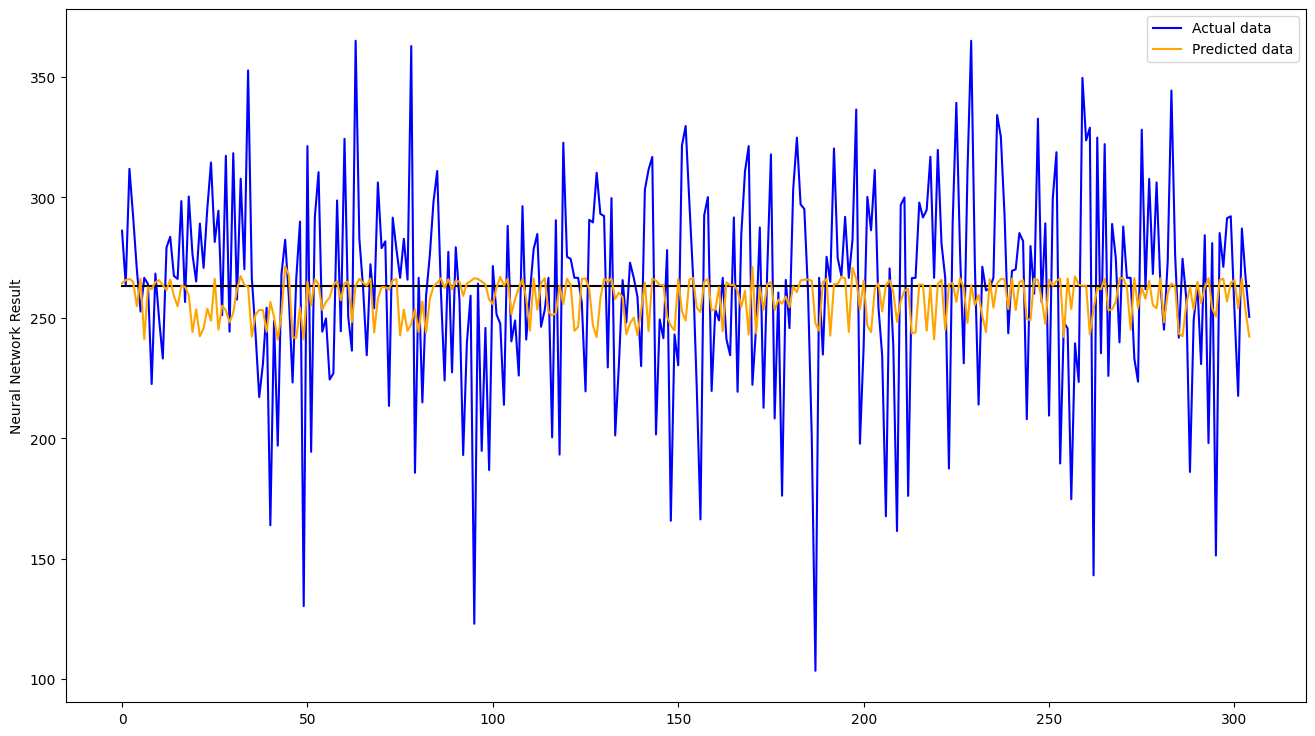

In [89]:
Axis = [y_val_inv[0].mean()] * len(y_val_inv[0])
plt.figure(figsize=(16, 9))
plt.ylabel('Neural Network Result')
plt.plot(y_val_inv[0], 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(nn_pred_inv[0], 'orange', label='Predicted data')
plt.legend()


# Comparision

https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean#:~:text=It%20means%20you've%20done,least%20squares%20regression%20line%20itself.

https://www.kaggle.com/questions-and-answers/267943

In [90]:
df_evaluation = pd.concat([lr_df, nn_df, dtr_df, rfr_df, xgbr_df]) 
df_evaluation

,mse,mae,rmse,r2,deviation
Linear Regression,1218.156182,26.722086,34.902094,-0.979636,0.103988
Neural Network,1789.929299,33.197497,42.307556,-26.266012,0.137975
Decision Tree Regression,3279.798949,45.385811,57.269529,-275.074483,0.204091
Random Forest Regression,2073.411023,33.935602,45.534723,-303.540524,0.121016
XGBoost Regression,2359.028818,37.075643,48.569834,-49.442872,0.129344


In [91]:
df_evaluation.to_csv("/content/drive/My Drive/DataMining/POC/LungCancer/Evaluation/Transform/optuna.csv")

# Save Model

In [92]:
import pickle
lr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Transform/lr_Optuna.h5'
pickle.dump(lr_model, open(lr_filename, 'wb'))
# svr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Transform/svr_Optuna.h5'
# pickle.dump(svr_model, open(svr_filename, 'wb'))
rfr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Transform/rfr_Optuna.h5'
pickle.dump(rfr_model, open(rfr_filename, 'wb'))
dtr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Transform/dtr_Optuna.h5'
pickle.dump(dtr_model, open(dtr_filename, 'wb'))
xgbr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Transform/xgbr_Optuna.h5'
pickle.dump(xgbr_model, open(xgbr_filename, 'wb'))
nn_mod.save(f'/content/drive/My Drive/DataMining/POC/LungCancer/Model/Transform/nn_Optuna.h5')